## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

https://github.com/udacity/nd320-c4-wearable-data-project-starter

### Code

In [2]:
import sys
!{sys.executable} -m pip install --upgrade numpy

    100% |████████████████████████████████| 13.4MB 2.5MB/s eta 0:00:01   27% |████████▊                       | 3.7MB 21.9MB/s eta 0:00:01    43% |██████████████                  | 5.8MB 21.9MB/s eta 0:00:01    57% |██████████████████▌             | 7.7MB 19.4MB/s eta 0:00:01    66% |█████████████████████▏          | 8.9MB 24.1MB/s eta 0:00:01    73% |███████████████████████▌        | 9.8MB 18.6MB/s eta 0:00:01    86% |███████████████████████████▊    | 11.6MB 17.9MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1


In [21]:
import glob

import numpy as np
import scipy as sp
import scipy.signal
import scipy.io

from matplotlib import pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)
    
    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate(model):
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = model.RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)






#-------#
# Model #
#-------#
class PulseRateModel:
    """
        PulseRateModel is an object which estimates, predicts the pulse rate of 
        a given ppg signal and a three-axis accelerometer
    
    """
    def __init__(self, fs = 125, 
                       BPM_min = 40, 
                       BPM_max = 240,
                       pass_band = (2 / 3, 4),
                       window_length = 8,
                       window_shift = 2,
                       k_dominant_frequencies = 4):
        self.fs = fs  # signals were sampled at 125 Hz
        self.BPM_min = BPM_min # min bpm
        self.BPM_max= BPM_max # max bpm
        
        # self.pass_band = (self.BPM_min/self.fs, self.BPM_max/self.fs * 3)
        self.pass_band = pass_band
        self.window_length = window_length * self.fs # 8 second time window
        self.window_shift = window_shift * self.fs  # 2 second shift to next window
        
        self.k_dominant_frequencies = k_dominant_frequencies

    def read_mat_file(self, data_fl):
        """
            Small wrapper around the LoadTroikaDataFile methode,
            to make it more realistic
        """
        return LoadTroikaDataFile(data_fl)
    
    
    def bandpass_filter(self, signal, order=3):
        """filters the signal between a given range, see self.pass_band

        Input:
            signal: input signal
            fs: Hz of input signal

        Output:
            filtered signal
        """

        b, a = scipy.signal.butter(order, self.pass_band, btype='bandpass', fs=self.fs)
        return scipy.signal.filtfilt(b, a, signal)
    
    
    
    def fourier_transformation(self, signal, n=2):
        """Calculate the fourier transform for each row in the signal matrix
           + return the fourier transformed frequencies

           input:
               signal a 2D signal matrix

            output:
                fft: N fourier transformations 
                freqs = frequency of the fourier transformation
        """

        # fourier transformation magnitude
        fft  = np.abs( np.fft.rfft(signal, n * signal.shape[1]) )

        # frequency
        freqs = np.fft.rfftfreq(n * signal.shape[1], 1 / self.fs)
        freqs = np.repeat(freqs[None,:], signal.shape[0], axis=0)
        return fft, freqs

    
    def calculate_confidence(self, freqs, fft_f, bpm_max):
        """
        Calculates the confidence value for a signal window

        Args:
            freqs : list of frequenqies
            fft_f : fourier transformed signal
            bpm_max: max frequency

        Returns:
            confidence value
        """
        fundamental_freq_window = (freqs > (bpm_max - self.BPM_min/60)) & (freqs < bpm_max + self.BPM_min/60)
        fft_t_sum = fft_f.sum(axis=1)
        fft_f[fundamental_freq_window == False] = 0
        return fft_f.sum(axis=1) / fft_t_sum


    def RunPulseRateAlgorithm(self, data_fl, ref_fl):
        """
        RunPulseRateAlgorithm is the main method to calculate the pulse rate.
        It combines all the small steps together into one algorithm.
        
        - reads the data
        - applies a bandpass filter
        - combines the three-axis accelerometer into 1 signal
        - creates data windows of the filtered signals
        - calculates the fourier transformations
        - filters the fourier transformations
        - selects the most potential frequencies
        - calculates the confidence and error
        
        Args:
            data_fl : filename of the signal data
            ref_fl : filename of the reference data
        Returns:
            error (MAE)
            confidence
        """
       
        # Load data using LoadTroikaDataFile
        ppg, accx, accy, accz = self.read_mat_file(data_fl)

        # Compute pulse rate estimates and estimation confidence.
        # apply bandpass_filter to clean the signal
        ppg = self.bandpass_filter(ppg, order=2)
        #accx = self.bandpass_filter(accx, order=2)
        #accy = self.bandpass_filter(accy, order=2)
        #accz = self.bandpass_filter(accz, order=2)
        
        # Combine the accelerometer into 1 accelerometer signal - magniture
        acc = (accx**2 + accy**2 + accz**2)**0.5
        acc = self.bandpass_filter(acc, order=2)
        
        # create ppg and acc windows
        # loop over the signal in steps of 2 x fs (window_shift) --> (0 250 500 750 1000 ...)
        # for each step --> take the first n x fs values (250 251 252 ...  250+N)
        # (there is enough data to use full windows)
        assert(acc.shape == ppg.shape)
        # Create Subsets of the whole series
        ppg_windows = np.array([(ppg[ i : i + self.window_length], 
                                 acc[ i : i + self.window_length])  for i in range(0, ppg.shape[0] - self.window_length, self.window_shift)\
                                                                     if i + self.window_length < ppg.shape[0]])

        # split the window into acc_windows & ppg_windows
        acc_windows = ppg_windows[:,1,:]
        ppg_windows = ppg_windows[:,0,:]
        
        
        # fft the ppg and acc signals        
        fft_ppg, ppg_freqs = self.fourier_transformation(ppg_windows, n=2)
        fft_acc, acc_freqs = self.fourier_transformation(acc_windows, n=2)

                
        # filter the signals
        fft_ppg[ppg_freqs <= (self.BPM_min / 60)] = 0
        fft_ppg[ppg_freqs >= (self.BPM_max / 60)] = 0

        fft_acc[acc_freqs <= (self.BPM_min / 60)] = 0
        fft_acc[acc_freqs >= (self.BPM_max / 60)] = 0
        
        #
        # Calculate the take the dominant ppg frequency
        # 
        
        k = self.k_dominant_frequencies
        
        # take k first most dominant frequencies
        # sort the frequencies matrices by the row axis (1)
        # take the last 4 frequencies
        # revert the order (the most frequent frequency is now at index 0)
        k_dominant_ppg_freqs =  np.take_along_axis(ppg_freqs, np.argsort(fft_ppg, axis=1)[:,-k:], axis=1)[:,::-1]
        k_dominant_acc_freqs =  np.take_along_axis(acc_freqs, np.argsort(fft_acc, axis=1)[:,-k:], axis=1)[:,::-1]

        # Select the the dominant ppg freq, which isn't the same as the most dom acc freq
        # create a matrix with size (N_windows x k)
        # [[0, 1, 2, 3],
        #  [0, 1, 2, 3],
        #  [0, 1, 2, 3],
        #       ...
        #  [0, 1, 2, 3]]
        #
        index_matrx = np.array([np.arange(k),] * fft_ppg.shape[0])
        
        # edit to k+1 if  k_dominant_ppg_freqs ==  k_dominant_ppg_freqs
        index_matrx[k_dominant_ppg_freqs == k_dominant_acc_freqs] = k+1

        # take the ppg_max, 
        # which is the min value
        ppg_max_indices = index_matrx.min(axis=1)[:,None]
        ppg_max_indices[ppg_max_indices == k+1] = 0 # if all of them were the same, take the first one
        
        # take the max ppg
        ppg_max = np.take_along_axis(k_dominant_ppg_freqs, ppg_max_indices, axis=1) 
        
        
        # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
        confidence = self.calculate_confidence(ppg_freqs.copy(), fft_ppg.copy(), ppg_max)
        bpm_pred = ppg_max*60

        # load the ground_truth
        ground_truth = sp.io.loadmat(ref_fl)['BPM0'][:len(bpm_pred)]

        # measure diff
        errors = np.abs(ground_truth - bpm_pred)
        return errors[:,0], confidence
    
model = PulseRateModel()
Evaluate(model)

20.30339606973278

# Step by Step
In this section we'regoing run over the whole process, step by step.  
In this way, we'll have a better view of what we're doing and how things are changing.

In [2]:
#---------------------#
# instpect parameters #
#---------------------#
inspect_index = 1
r_start = 10000
r_end = 11000

## Load the data

In [3]:
# load the model as self --> in this way i dont have to modify the code
self = PulseRateModel()

# Retrieve dataset files
data_fls, ref_fls = LoadTroikaDataset()

 # Load data using LoadTroikaDataFile
data_fl, ref_fl = data_fls[inspect_index], ref_fls[inspect_index]
ppg, accx, accy, accz = self.read_mat_file(data_fl)


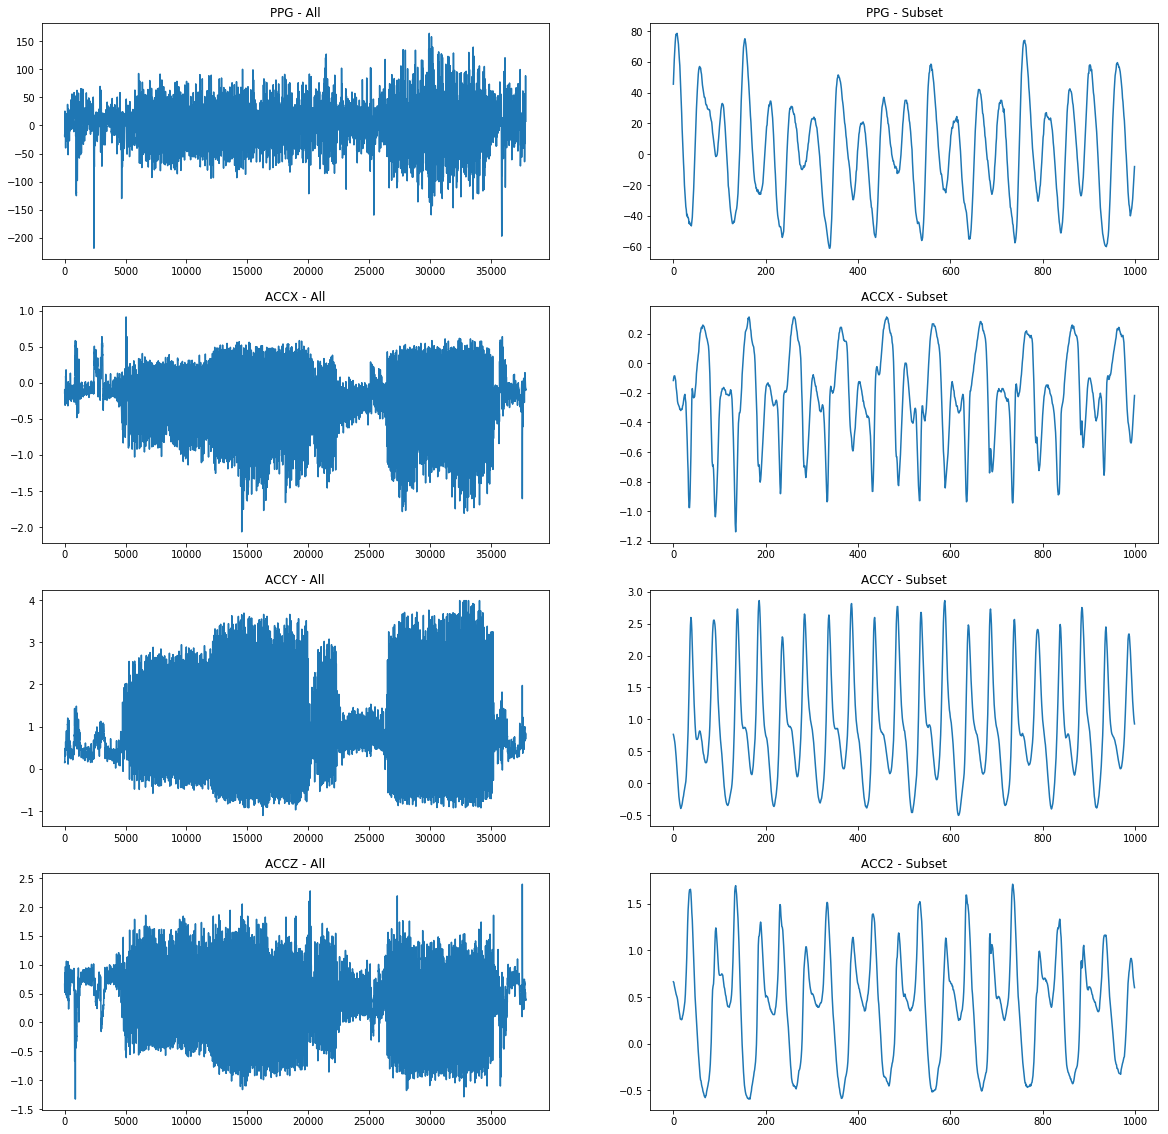

In [4]:
#---------------#
# Plot the data #
#---------------#
plt.figure(figsize=(20, 20))
plt.subplot(4,2,1)
plt.title('PPG - All')
plt.plot(ppg)
plt.subplot(4,2,2)
plt.title('PPG - Subset')
plt.plot(ppg[r_start:r_end])
plt.subplot(4,2,3)
plt.title('ACCX - All')
plt.plot(accx)
plt.subplot(4,2,4)
plt.title('ACCX - Subset')
plt.plot(accx[r_start:r_end])
plt.subplot(4,2,5)
plt.title('ACCY - All')
plt.plot(accy)
plt.subplot(4,2,6)
plt.title('ACCY - Subset')
plt.plot(accy[r_start:r_end])
plt.subplot(4,2,7)
plt.title('ACCZ - All')
plt.plot(accz)
plt.subplot(4,2,8)
plt.title('ACC2 - Subset')
plt.plot(accz[r_start:r_end])
pass

## Apply the bandpass_filter

In [5]:
# take a copy of the current result
ppg_raw = ppg.copy()
accx_raw = accx.copy()
accy_raw = accy.copy()
accz_raw = accz.copy()

In [6]:
(self.BPM_min/self.fs, self.BPM_max/self.fs)

(0.32, 1.92)

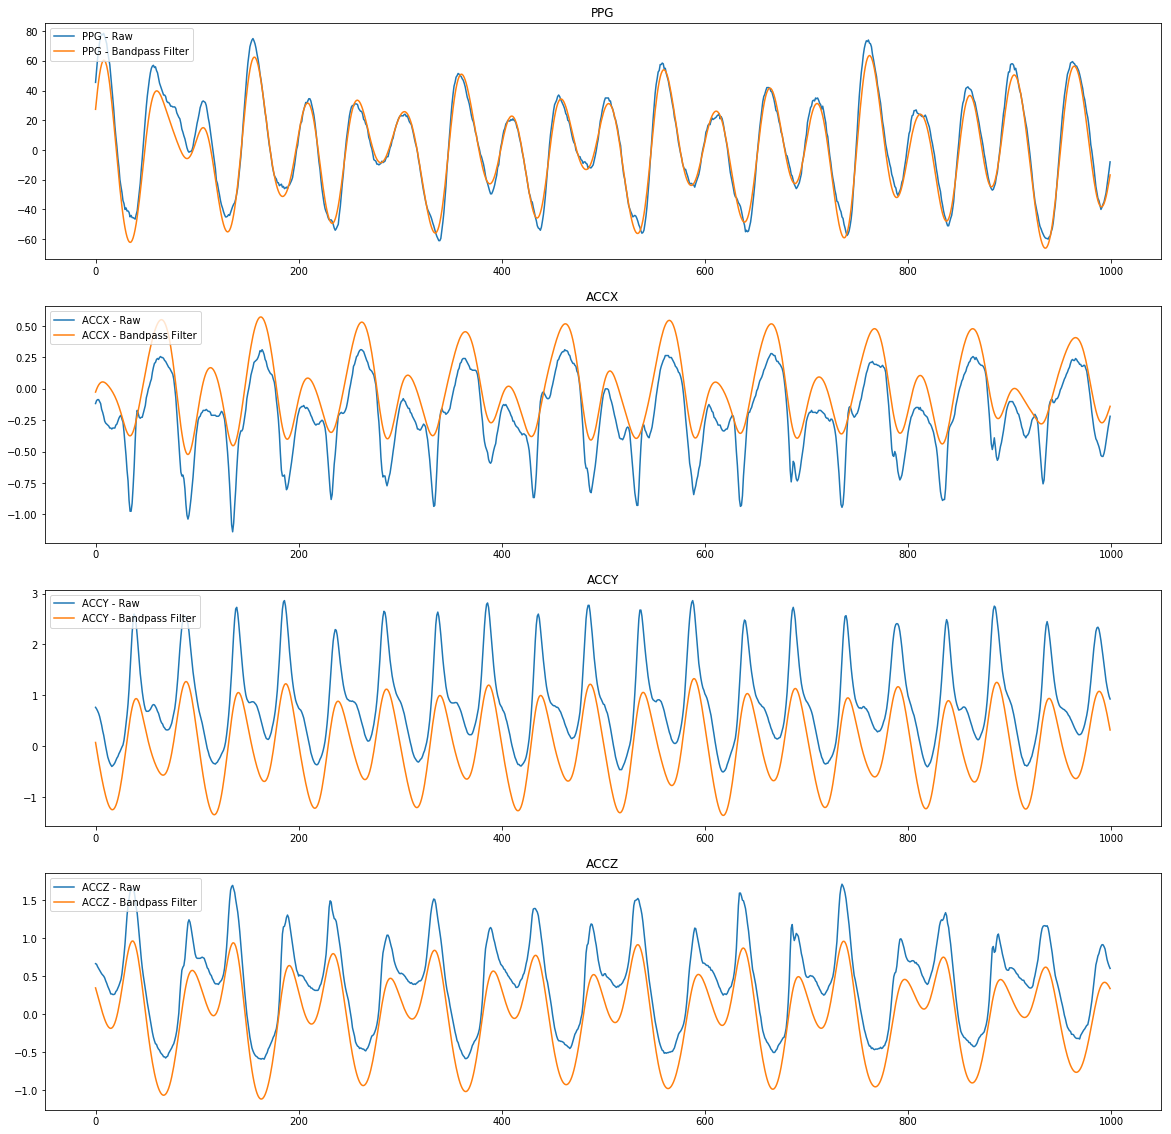

In [7]:
# apply bandpass_filter to clean the signal
order = 2

ppg = self.bandpass_filter(ppg_raw, order)
accx = self.bandpass_filter(accx_raw, order)
accy = self.bandpass_filter(accy_raw, order)
accz = self.bandpass_filter(accz_raw, order)

#---------------#
# Plot the data #
#---------------#
plt.figure(figsize=(20, 20))
plt.subplot(4,1,1)
plt.title('PPG')
plt.plot(ppg_raw[r_start:r_end], label="PPG - Raw")
plt.plot(ppg[r_start:r_end], label="PPG - Bandpass Filter")
plt.legend(loc="upper left")
plt.subplot(4,1,2)
plt.title('ACCX')
plt.plot(accx_raw[r_start:r_end], label="ACCX - Raw")
plt.plot(accx[r_start:r_end], label="ACCX - Bandpass Filter")
plt.legend(loc="upper left")
plt.subplot(4,1,3)
plt.title('ACCY')
plt.plot(accy_raw[r_start:r_end], label="ACCY - Raw")
plt.plot(accy[r_start:r_end], label="ACCY - Bandpass Filter")
plt.legend(loc="upper left")
plt.subplot(4,1,4)
plt.title('ACCZ')
plt.plot(accz_raw[r_start:r_end], label="ACCZ - Raw")
plt.plot(accz[r_start:r_end], label="ACCZ - Bandpass Filter")
plt.legend(loc="upper left")
pass

## Combine the accelerometer

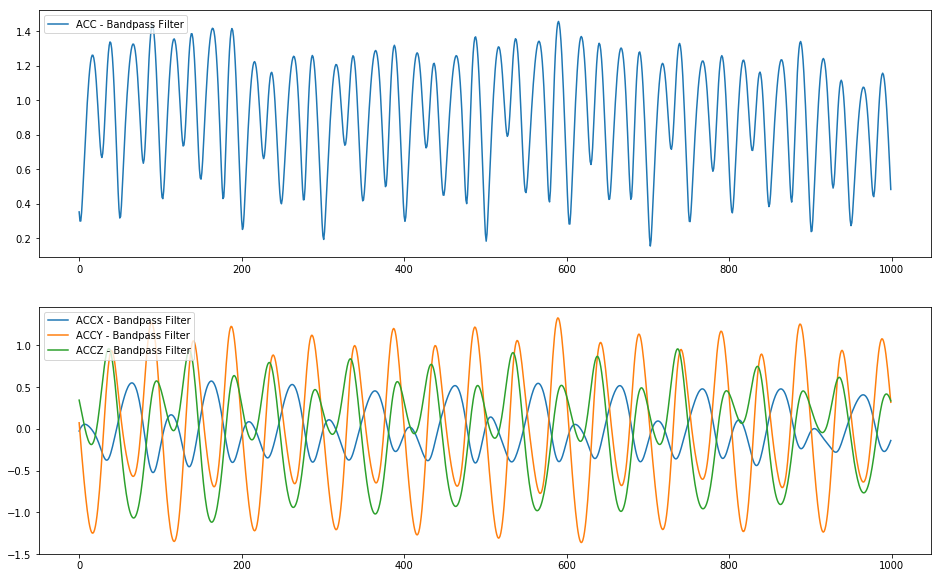

In [8]:
# Combine the accelerometer
acc = (accx**2 + accy**2 + accz**2)**0.5

# inspect the data
plt.figure(figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(acc[r_start:r_end], label="ACC - Bandpass Filter")
plt.legend(loc="upper left")
plt.subplot(2,1,2)
plt.plot(accx[r_start:r_end], label="ACCX - Bandpass Filter")
plt.plot(accy[r_start:r_end], label="ACCY - Bandpass Filter")
plt.plot(accz[r_start:r_end], label="ACCZ - Bandpass Filter")
plt.legend(loc="upper left")
pass

# Specgram plots

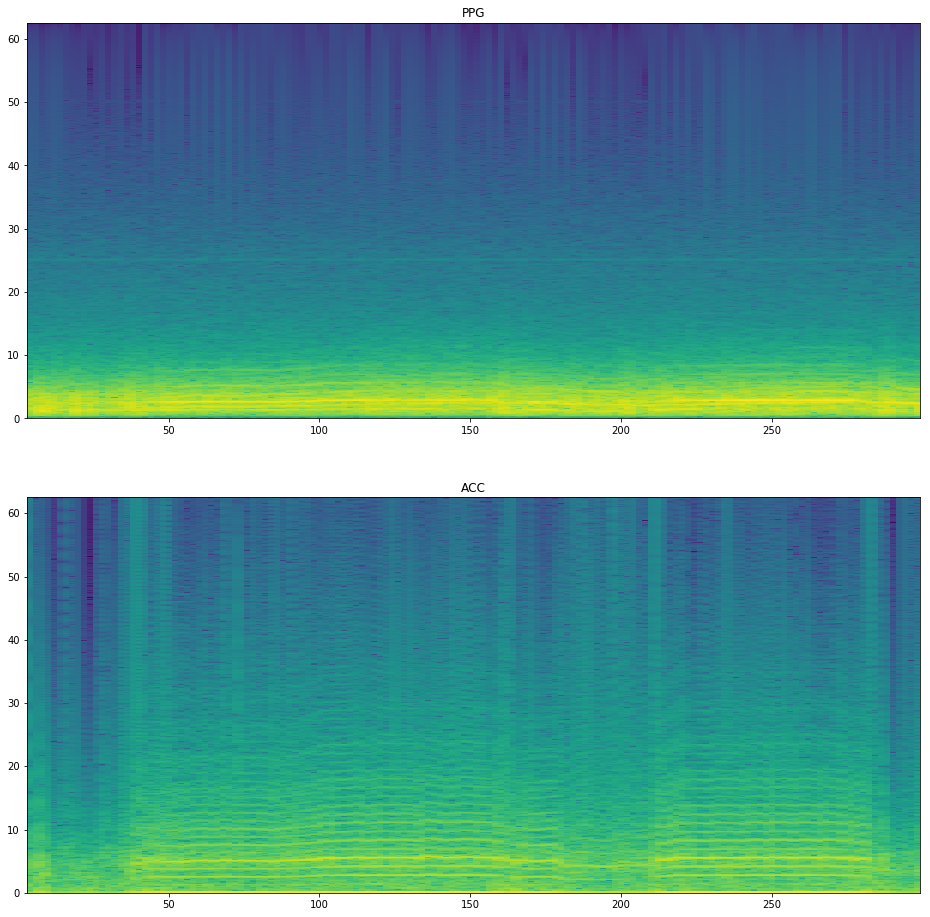

In [9]:
plt.figure(figsize=(16, 16))
plt.subplot(2,1,1)
plt.title('PPG')
plt.specgram(ppg, Fs = self.fs, NFFT = 8 * self.fs, noverlap=6 * self.fs);

plt.subplot(2,1,2)
plt.title('ACC')
plt.specgram(acc, Fs = self.fs, NFFT = 8 * self.fs, noverlap=6 * self.fs);

## Create subsets

In [10]:
# subset which we will inspect
i_subset = 45

In [11]:
# Create Subsets of the whole series
ppg_windows = np.array([(ppg[ i : i + self.window_length], 
                         acc[ i : i + self.window_length])  for i in range(0, ppg.shape[0] - self.window_length, self.window_shift)\
                                                             if i + self.window_length < ppg.shape[0]])

# split the window into acc_windows & ppg_windows
acc_windows = ppg_windows[:,1,:]
ppg_windows = ppg_windows[:,0,:]

print(ppg_windows.shape, acc_windows.shape)

(148, 1000) (148, 1000)


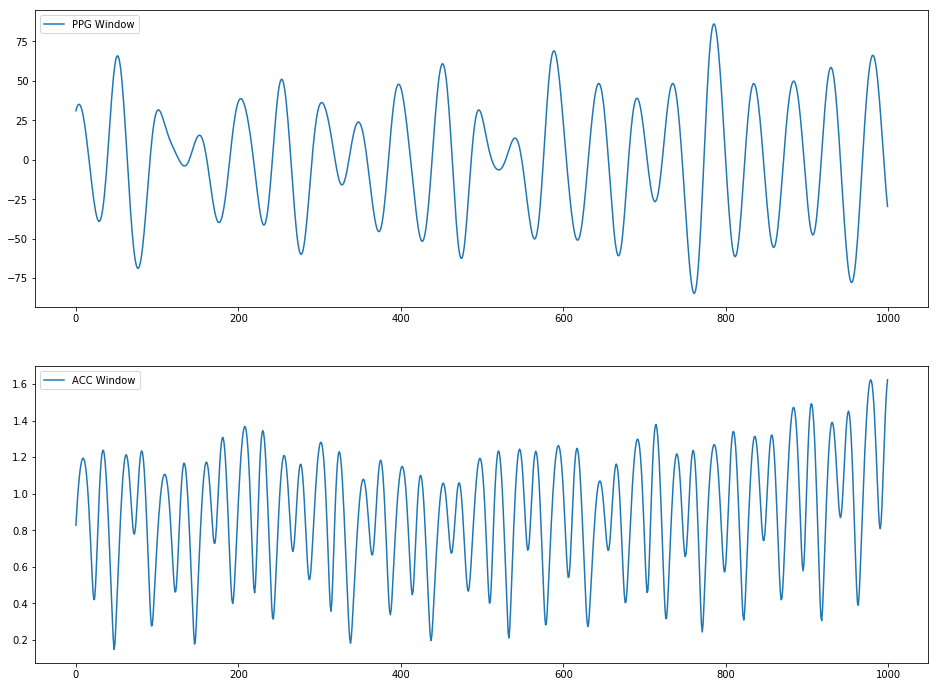

In [12]:
# inspect the data
plt.figure(figsize=(16, 12))

plt.subplot(2,1,1)
plt.plot(ppg_windows[i_subset], label="PPG Window")
plt.legend(loc="upper left")
plt.subplot(2,1,2)
plt.plot(acc_windows[i_subset], label="ACC Window")
plt.legend(loc="upper left")
pass

## Calculate the fast fourier transformations

In [13]:
# fft the ppg and acc signals
fft_ppg_raw, ppg_freqs = self.fourier_transformation(ppg_windows, n=2)
fft_acc_raw, acc_freqs = self.fourier_transformation(acc_windows, n=2)

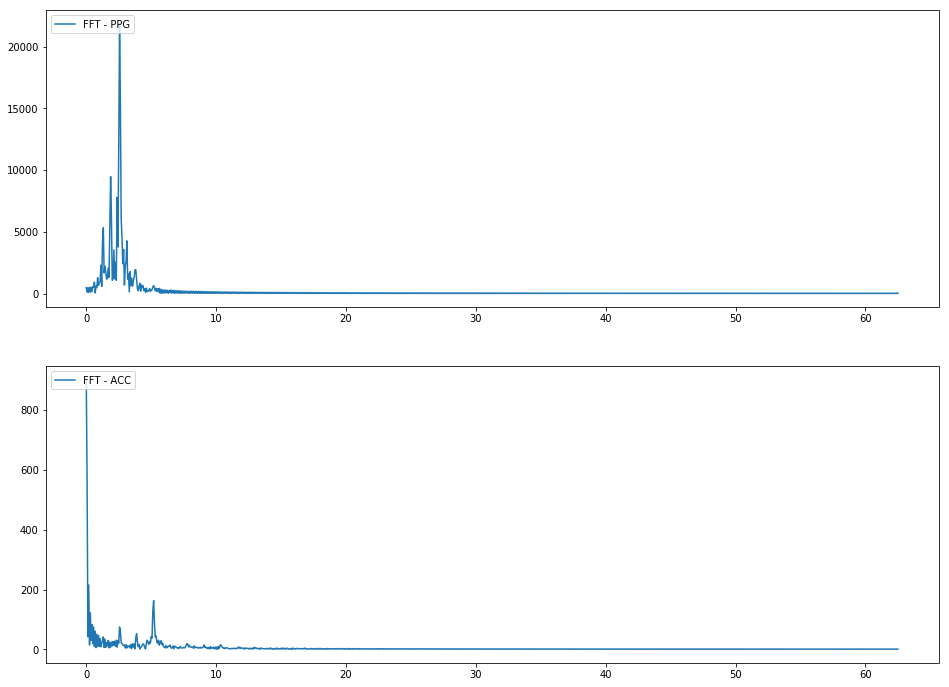

In [14]:
plt.figure(figsize=(16, 12))
plt.subplot(2,1,1)
plt.plot(ppg_freqs[i_subset], fft_ppg_raw[i_subset], '-', label="FFT - PPG")
plt.legend(loc="upper left")
plt.subplot(2,1,2)
plt.plot(acc_freqs[i_subset], fft_acc_raw[i_subset], '-', label="FFT - ACC")
plt.legend(loc="upper left")
pass

## Filter the fast fouriers

In [15]:
fft_ppg = fft_ppg_raw.copy()
fft_acc = fft_acc_raw.copy()

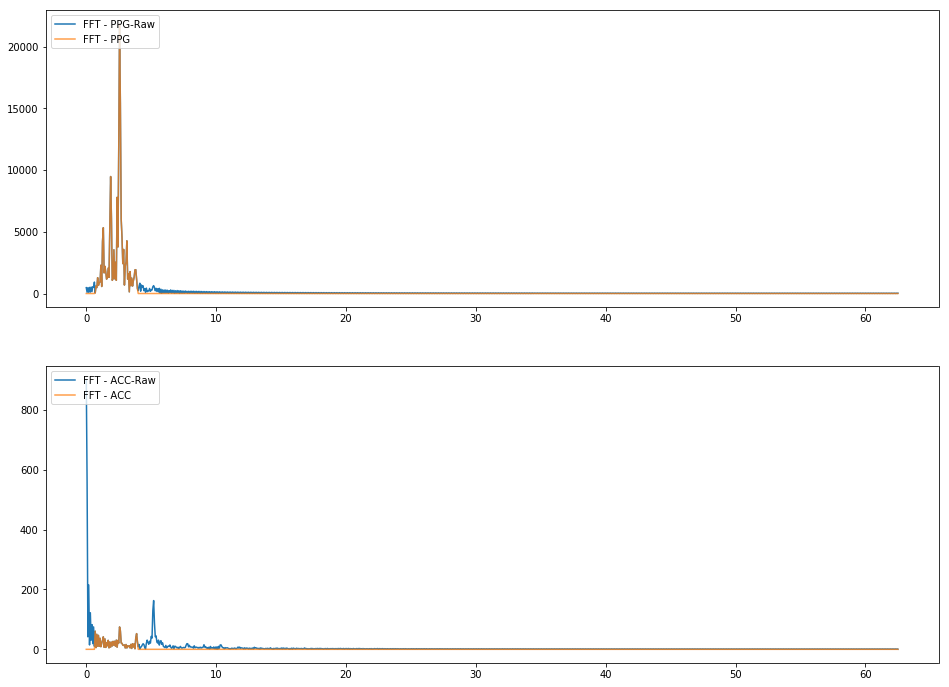

In [16]:
# filter the signals
fft_ppg[ppg_freqs <= (self.BPM_min / 60)] = 0
fft_ppg[ppg_freqs >= (self.BPM_max / 60)] = 0

fft_acc[acc_freqs <= (self.BPM_min / 60)] = 0
fft_acc[acc_freqs >= (self.BPM_max / 60)] = 0

#-----------------#
# show the filter #
#-----------------#

plt.figure(figsize=(16, 12))
plt.subplot(2,1,1)
plt.plot(ppg_freqs[i_subset], fft_ppg_raw[i_subset], '-', label="FFT - PPG-Raw")
plt.plot(ppg_freqs[i_subset], fft_ppg[i_subset], '-', label="FFT - PPG", alpha=0.75)
plt.legend(loc="upper left")
plt.subplot(2,1,2)
plt.plot(acc_freqs[i_subset], fft_acc_raw[i_subset], '-', label="FFT - ACC-Raw")
plt.plot(acc_freqs[i_subset], fft_acc[i_subset], '-', label="FFT - ACC",  alpha=0.75)
plt.legend(loc="upper left")
pass

## Fundamental Frequencies for PPG and ACC
Freq with Max value per PPG and ACC

In [17]:
#
# Calculate the take the dominant ppg frequency
# 

k=4

# take k first most dominant frequencies
# sort the frequencies matrices by the row axis (1)
# take the last 4 frequencies
# revert the order (the most frequent frequency is now at index 0)
k_dominant_ppg_freqs =  np.take_along_axis(ppg_freqs, np.argsort(fft_ppg, axis=1)[:,-k:], axis=1)[:,::-1]
k_dominant_acc_freqs =  np.take_along_axis(acc_freqs, np.argsort(fft_acc, axis=1)[:,-k:], axis=1)[:,::-1]

# Select the the dominant ppg freq, which isn't the same as the most dom acc freq
# create a matrix with size (N_windows x k)
# [[0, 1, 2, 3],
#  [0, 1, 2, 3],
#  [0, 1, 2, 3],
#       ...
#  [0, 1, 2, 3]]
#
index_matrx = np.array([np.arange(k),] * fft_ppg.shape[0])

# edit to k+1 if  k_dominant_ppg_freqs ==  k_dominant_ppg_freqs
index_matrx[k_dominant_ppg_freqs == k_dominant_acc_freqs] = k+1

# take the ppg_max, 
# which is the min value
ppg_max_indices = index_matrx.min(axis=1)[:,None].copy()
ppg_max_indices[ppg_max_indices == k+1] = 0 # if all of them were the same, take the first one

acc_max_indices = index_matrx.min(axis=1)[:,None].copy()
acc_max_indices[acc_max_indices == k+1] = 0 # if all of them were the same, take the first one

# take the max ppg
ppg_max = np.take_along_axis(k_dominant_ppg_freqs, ppg_max_indices, axis=1) 
acc_max = np.take_along_axis(k_dominant_acc_freqs, acc_max_indices, axis=1) 

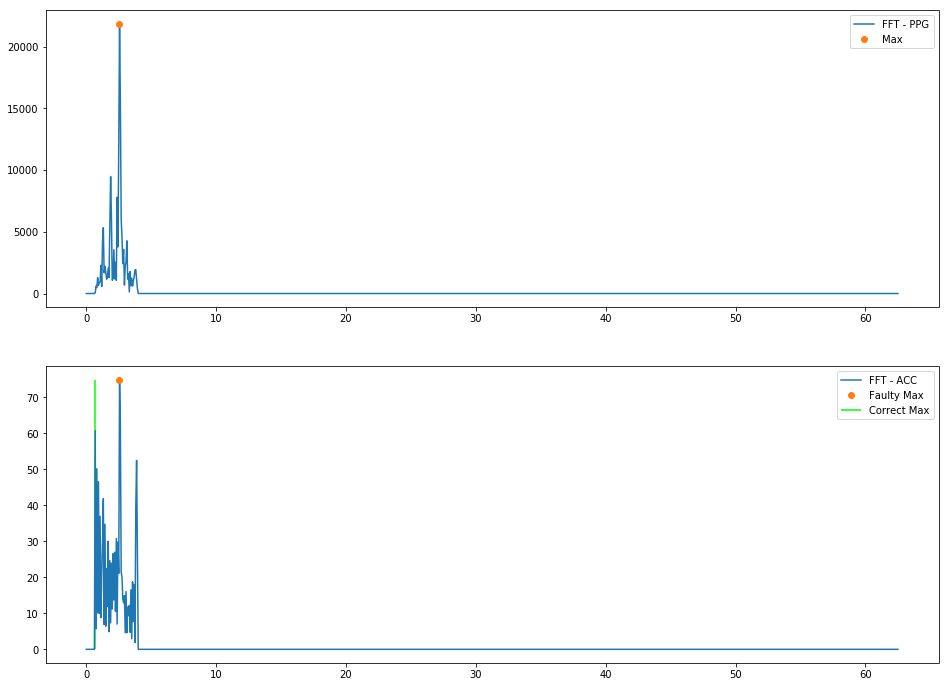

In [18]:
#-----------------#
# show the filter #
#-----------------#

plt.figure(figsize=(16, 12))
plt.subplot(2,1,1)
plt.plot(ppg_freqs[i_subset], fft_ppg[i_subset], '-', label="FFT - PPG")
plt.plot(ppg_max[i_subset], fft_ppg[i_subset].max(), 'o', label="Max")
plt.legend(loc="upper right")

plt.subplot(2,1,2)
plt.plot(acc_freqs[i_subset], fft_acc[i_subset], '-', label="FFT - ACC")
plt.plot(ppg_max[i_subset], fft_acc[i_subset].max(), 'o', label="Faulty Max")
plt.vlines(acc_max[i_subset], 0,  fft_acc[i_subset].max(), colors= "#00ff00",label="Correct Max")
plt.legend(loc="upper right")
pass

## Calculate the confidence

In [19]:
# Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
confidence = self.calculate_confidence(ppg_freqs.copy(), fft_ppg.copy(), ppg_max)
bpm_pred = ppg_max*60

'Confidene : 0.30285019459360635'

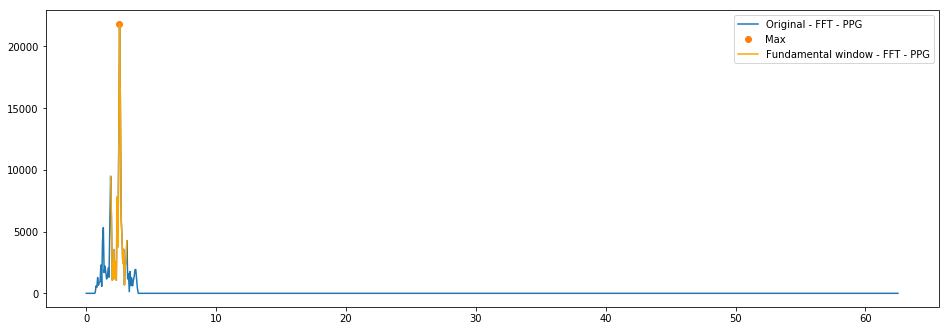

In [45]:
# methode inputs
bpm_max = ppg_max[i_subset]
freqs = ppg_freqs[i_subset]
fft_f = fft_ppg[i_subset]

plt.figure(figsize=(16, 12))

#--------------------------#
# Show the original values #
#--------------------------#
plt.subplot(2,1,1)
plt.plot(ppg_freqs[i_subset], fft_ppg[i_subset], '-', label="Original - FFT - PPG")
plt.plot(ppg_max[i_subset], fft_ppg[i_subset].max(), 'o', label="Max")

#------------------------------------------#
# select the specific range of frequencies #
#------------------------------------------#
fundamental_freq_window = (freqs > (bpm_max - self.BPM_min/60)) & (freqs < bpm_max + self.BPM_min/60)

# show
plt.plot(ppg_freqs[i_subset][fundamental_freq_window], fft_ppg[i_subset][fundamental_freq_window], '-', label="Fundamental window - FFT - PPG", color='orange')
plt.legend(loc="upper right")


#--------------------------#
# Calculate the confidence #
#--------------------------#
f"Confidene : {fft_f[fundamental_freq_window == False].sum() / fft_f.sum()}"

## loading the reference file

In [24]:
# load the ground_truth
ground_truth = sp.io.loadmat(ref_fl)['BPM0'][:len(bpm_pred)]

# measure diff
errors = np.abs(ground_truth - bpm_pred)
errors[:,0], confidence

(array([5.99576271e+00, 2.60214908e+01, 2.88425926e+01, 2.52467638e+01,
        1.68644544e+01, 2.50677140e+00, 2.65078918e+00, 5.84599028e+00,
        1.03846154e+01, 3.28014184e-01, 4.14364641e-01, 1.79180887e+00,
        1.06790800e+00, 1.80194805e+00, 7.07296651e+01, 6.92340371e+01,
        6.53005985e+01, 5.69562955e+01, 1.31058282e+01, 1.95090759e+01,
        5.64625850e+01, 5.51724138e+01, 4.98902570e+01, 4.89527027e+01,
        4.75657895e+01, 4.51089212e+01, 4.25633641e+01, 4.51612903e+01,
        4.50484392e+01, 4.59445037e+01, 4.61661342e+01, 4.66065748e+01,
        4.66065748e+01, 4.66704937e+01, 4.67161017e+01, 4.63133641e+01,
        4.94719251e+01, 4.89770081e+01, 4.34426230e+01, 4.15289256e+01,
        4.01673640e+01, 3.92045455e+01, 3.88888889e+01, 4.24032344e+01,
        4.15705128e+01, 4.10890558e+01, 4.41090713e+01, 4.31209150e+01,
        4.53559603e+01, 4.38178497e+01, 4.58262712e+01, 4.42918455e+01,
        4.29826464e+01, 4.17798467e+01, 4.05186722e+01, 3.921383

-----
### Project Write-up

**Code Description** 
 - Packages used:
    - glob
    - matplotlib == 2.1.0    
    - numpy == 1.19.5 
    - scipy == 1.2.1   
     
     
 - PulseRateModel
   - PulseRateModel is an model (object) that allows you to run the RunPulseRateAlgorithm algorithm.
   By default, the RunPulseRateAlgorithm() method requires 2 file names, one of the training data and one of the reference data. Nevertheless, the *model* also allows you to configure the most important hyperparameters. You can set these when initializing the model (see init).
     
     
 - Parameters:
   (The default parameters give you a good result)
    - fs = 125 | datapoints per second
    - BPM_min = 40  | A minimum signal threshold.
    - BPM_max = 240 | A maximim signal threshold.
    - pass_band = (2 / 3, 4) | The critical frequency or frequencies. For lowpass and highpass filters.
    - window_length = 8 | The length in seconds of one window
    - window_shift = 2 | The amount of seconds between two startpoints of a window
    - k_dominant_frequencies = 4 | Amount of dominant frequencies you want to take into account   
          
          
 - Code Evaluation:  
   If you wish to evaluate the code, you must create a model object and run it through the *Evaluate* method.  
   ```python
   model = PulseRateModel()
   Evaluate(model)
   ```

   The Evaluate methode will perform the next steps:
   1. Load the datasets ( Troika dataset )
   1. Calculate the pulse rate using the PulseRateModel
   1. Returns the aggregate error metric
   
    
**Data Description**  
 - The data is sampled from 12 different particiants with a sample rate of 125Hz and contains the next items:
   1. A PPG signal 
   1. A three-axis accelerometer
   1. An ECG signals from subjects with ages from 18 to 35.
     
     
 - *Info abouth the data recording*

> The creators of the dataset simultaneously recorded a single-channel PPG signal, a three-axis acceleration signal, and an ECG signal from 12
male subjects with yellow skin and ages ranging from 18 to 35. For each subject, the PPG signal was recorded from
wrist using a pulse oximeter with green LED (wavelength: 515nm). The acceleration signal was also recorded from wrist
using a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband, which was
comfortably worn. The ECG signal was recorded from the chest using wet ECG sensors. All signals were sampled at 125 Hz.
During data recording subjects walked or ran on a treadmill with the following speeds in order: the speed of 1-2 km/hour
for 0.5 minute, the speed of 6-8 km/hour for 1 minute, the speed of 12-15 km/hour for 1 minute, the speed of 6-8 km/hour
for 1 minutes, the speed of 12-15 km/hour for 1 minute, and the speed of 1-2 km/hour for 0.5 minute. The subjects were
asked to purposely use the hand with the wristband to pull clothes, wipe sweat on forehead, and push buttons on the
treadmill, in addition to freely swing. 

From the above information, we can read that the data was recorded in ideal conditions, on a threadmill (probably indoors as well). In this way, external factors such as weather, humidity, temperature and the type of surface, were not taken into account. Also, there is a limited amount of information about the 12 male subjects. We don't know if they are spoiled runners or not. (An athlete may have a more elegant running style and a lower heart rate then a non athlete)


for extra information see: 
 - [https://arxiv.org/pdf/1409.5181.pdf]  
 
**Algorithhm Description** 

 - *Working*:
   1. Load the data
   1. Combina the three-axis accelerometer into 1 signal (ACC)
   1. Apply a badnpass filter on the PPG and ACC signal.
   1. Create windows of 8 seconds each, with a shift of 2 seconds
   1. Apply the Fourier Transformation on the PPG and ACC signals to get the FFT values and frequencies (for each window)
   1. Filter, clean the data 
   1. Find the dominant frequencies (in each window)  
   .1 If the dominant frequencies of the PPG signal and ACC signal are the same, take then the next most dominant frequency
   1. Calculate the MAE between the reference pulse rate and the predicted (estimated) pulse rate
   1. Calculate the confidence
   

 - *The physics*
   - Pulse rate is typically estimated by using the PPG sensor. When the ventricles contract, the capillaries in the wrist fill with blood. The (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capillaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate.

 - *A description of the algorithm outputs*
   - The algorithm predicts | estimates the pulse rate (in BPM) along with confidence estimates. A high confidence value means that the prediction should be more accurate than an prediction with a lower confidence value.
   In the above section *Calculate the confidence*, you can see that we took the sum of the frequency spectrum near the pulse rate (in orange) and divided it by the sum of the entire spectrum (blue). In essence, this means that we are saying that we are more confident of our predictions if the subset (orange) contains all the values of the entire spectrum. If the sum of our subset is only a fraction of the whole spectrum, then we are not very confident.  
   
 - *Caveats on algorithm outputs*
   - The algorithm can be affected by noise through other sources.
      (like movement)
   
 - *Common failure modes*
   - The algorithm may be affected by arm and finger motion.


 
**Algorithm Performance**
 - To evaluate the performance of our model, we calculate the MAE (mean absolute error).
   - To calculate this mean Absolute error, we take the average over the absolute differences between the predicted pulse rates and the real (reference) pulse rates :
    $$MAE = (\frac{1}{n})\sum_{i=1}^{n}\left | y_{i} - x_{i} \right |$$
 - MAE on the testset: 4.19
 - Even though the model performs well (i think). We only have data for 12 participants. These participants can be big, small, skinny or even fat. We do know that they were male and light skinned.  
 To make this model more robust, we would need more data from each category (also females and dark skinned people). This has the advantage that we can create more personalized models by applying clustering and segmentation on our participants. For example, if the person is female, tall, light-skinned, with a low BMI, then we can use a model trained on that kind of similar data.
 - At this moment we do also assume that they use the same kind of hardware. E.g. if you make an android app then the sensors may be from different manufacturers and or calibrated differently.
 
 

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 